# `base` - Testing of basic data handling operations

This notebook aims at testing the [`base`](https://github.com/eurostat/pygridmap/blob/master/pygridmap/base.py) module of the [`pygridmap`](https://github.com/eurostat/pygridmap) packages by running basic/simple examples over the following classes: 
* `FrameProcessor` for embarassing parallel calculations on dataframe rows (see [test 1](#TestFrameProcessor)), 
* `GridProcessor` for basic geometric operations on vector layers (see [test 2](#TestGridProcessor)).

## Settings<a id='Settings'></a>

Let's import the necessary packages. First the basic ones:

In [1]:
import os, sys
import itertools
import math, time, timeit

then, common (geospatial) data handling libraries:

In [2]:
import numpy as np

try:
     import pandas as pd
except ImportError:
    try:
        !{sys.executable} -m pip install pandas
    except:
        raise IOError("!!! Error importing pandas - this package is required !!!")
    else:
        import pandas as pd
        
try:
    import geopandas as gpd
except ImportError:
    try:
        !{sys.executable} -m pip install geopandas
    except:
        raise IOError("!!! Error importing geopandas - this package is required !!!")    else:
        import geopandas as gpd


We also set the CPUs capabilties of this machine:

In [3]:
import multiprocessing as mp

NPROCESSES = NCPUS = mp.cpu_count() 
print("You are running on a machine with \033[1m%s CPUs\033[0m" % NCPUS)

You are running on a machine with 32 CPUs


as well as the plotting package:

In [4]:
import matplotlib.pyplot as mplt
from matplotlib import cm
_FIGSIZE_, _DPI_ = (10,8), 140 
%matplotlib inline

Finally, we import the `pygridmap` package ( _"whatever works"_ ):

In [5]:
try:
    import pygridmap
except ImportError:
    try:
        # import google.colab
        !{sys.executable} -m pip install git+https://github.com/eurostat/pygridmap.git
        # !{sys.executable} -m pip install pygridmap
    except:
        raise IOError("Sorry, you're doomed: package pygridmap not installed !")
    else:
        print("! Package pygridmap installed on-the-fly !")
finally:        
    from pygridmap.base import FrameProcessor, GridProcessor

## Miscellaneous  testings

We test the basic methods from the class `FrameProcessor` that are use for embarassing parallel processing of dataframe rows: <a id='TestFrameProcessor'></a>

In [6]:
def test_row_sumfunc(row):
    return row['col1'] + row['col2']
def test_data_sumfunc(data):
    data['new'] = data.apply(lambda row: test_row_sumfunc(row), axis=1) 
    return data

def testFrameProcessor(ndata):
    # Test - Run parallel process on rows
    data = pd.DataFrame(columns=['col1','col2'])
    data['col1'] = np.random.normal(size = ndata)
    data['col2'] = np.random.normal(size = ndata)

    proc = FrameProcessor(cores=NCPUS)

    def base_apply(): return test_data_sumfunc(data)
    def parallel(): return proc(data, test_data_sumfunc)
    def parallel_on_row(): return proc.on_row(data, test_row_sumfunc)

    print('TEST - Run sequential vs. parallel "apply" operations on dataframes w/ %s rows - %s CPUs - TEST'
         % (ndata, NCPUS))
    t_1 = timeit.Timer(lambda: base_apply())
    print('\tsequential approach:', t_1.timeit(number=1))
    t_2 = timeit.Timer(lambda: parallel())
    print('\tparallel approach #1:', t_2.timeit(number=1))
    t_3 = timeit.Timer(lambda: parallel_on_row())
    print('\tparallel approach #2:', t_3.timeit(number=1))

In [7]:
NDATA = 1000 
testFrameProcessor(NDATA)

TEST - Run sequential vs. parallel "apply" operations on dataframes w/ 1000 rows - 32 CPUs - TEST
	sequential approach: 0.020718940068036318
	parallel approach #1: 0.15413783537223935
	parallel approach #2: 0.14461460011079907


In [8]:
NDATA = 1000000 if NCPUS>8 else 50000
testFrameProcessor(NDATA)

TEST - Run sequential vs. parallel "apply" operations on dataframes w/ 1000000 rows - 32 CPUs - TEST
	sequential approach: 18.304127151612192
	parallel approach #1: 1.4526958060450852
	parallel approach #2: 1.4626264506950974


We also test the generic (abstract) class for geometric processing, including the definition of bounding boxes, the definition of grid and tiling systems, *etc...*:<a id='TestGridProcessor'></a>

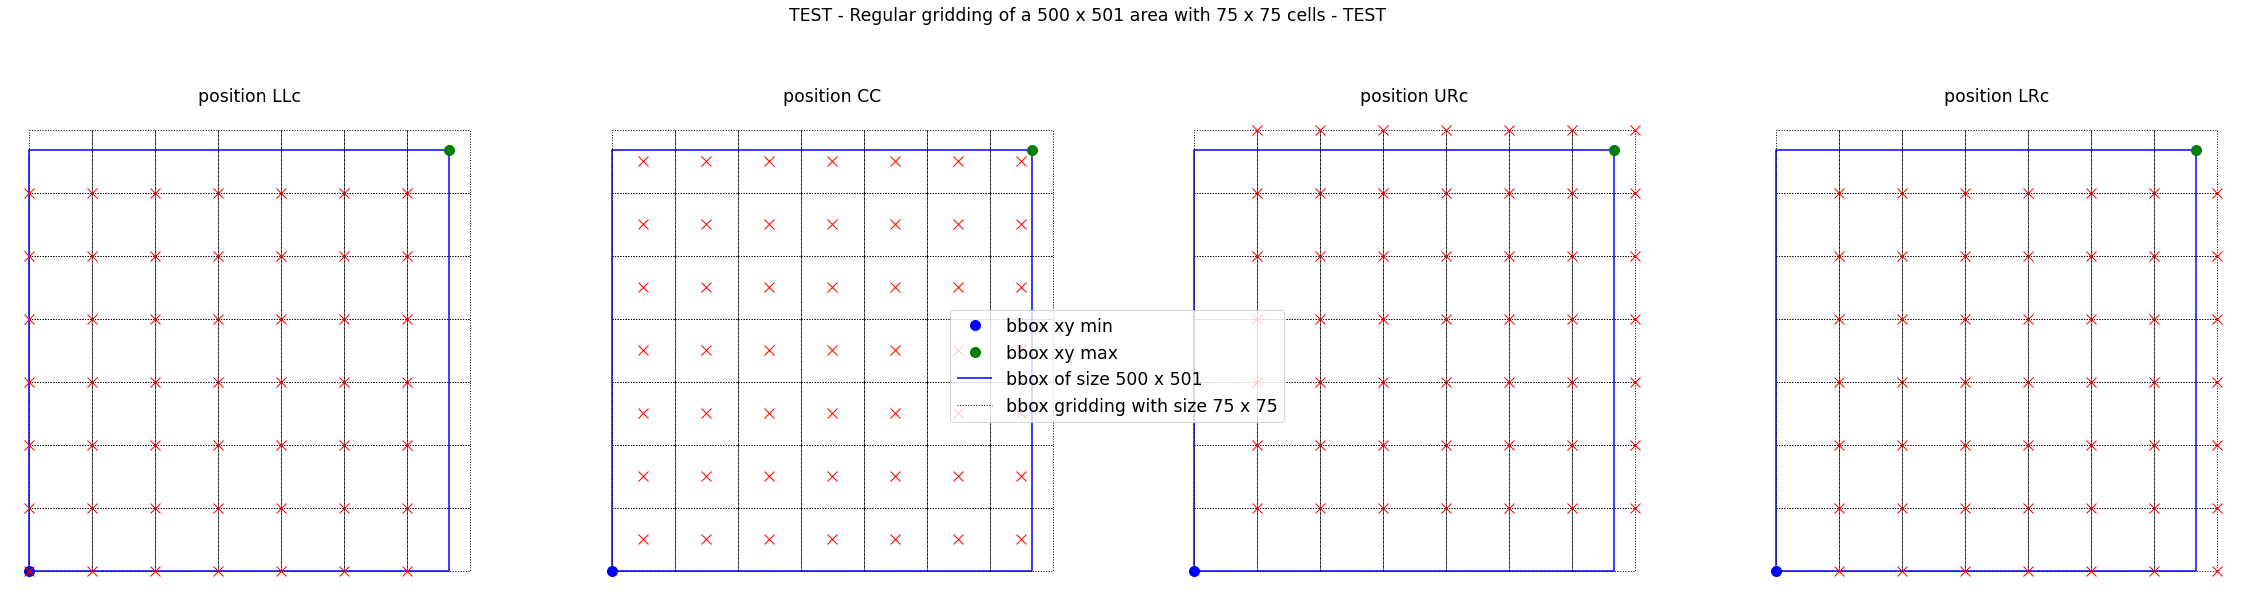

In [9]:
def testGridProcessor(cellsize, bbox, crs):
    # Test 1 - Building a basic regular grid and extracting corners/centres
    xxmin, yymin, xxmax, yymax = bbox
    frame = GridProcessor.bbox_to_geoframe(*bbox, crs = crs)
    rows, cols = GridProcessor.get_pos_location(cellsize, bbox)
    polygon = GridProcessor.build_from_pos(cellsize, rows, cols)
    gridtest = gpd.GeoDataFrame({'geometry':polygon}, crs = crs)
    gridbbox = gridtest.total_bounds
    f, ax = mplt.subplots(1, 4, figsize = (40,10))
    for i, pos in enumerate(['LLc', 'CC', 'URc', 'LRc']): 
        rows, cols = GridProcessor.get_pos_location(cellsize, gridbbox, pos = pos)
        ax[i].plot(xxmin, yymin, 'bo', markersize = 10, label = 'bbox xy min')
        ax[i].plot(xxmax, yymax, 'go', markersize = 10, label = 'bbox xy max')
        frame.boundary.plot(ax = ax[i], edgecolor = 'b', linewidth = 1.5, 
                            label = 'bbox of size %s x %s'% (bbox[2]-bbox[0], bbox[3]-bbox[1]))
        gridtest.boundary.plot(ax = ax[i], edgecolor = 'k', linestyle = 'dotted', linewidth = 1, 
                               label = 'bbox gridding with size %s x %s' % (cellsize[0],cellsize[1]))
        [ax[i].plot(c, r, 'rx', markersize = 10) for c, r in itertools.product(cols, rows)]
        ax[i].set_title('position %s'% pos, fontsize = 'xx-large')
        ax[i].set_axis_off(); ax[i].set_axis_off(); # ax[i].legend(loc=7)
        if i == 2:  ax[i].legend(fontsize = 'xx-large', bbox_to_anchor = (0.25, 0.6))
        f.suptitle('TEST - Regular gridding of a 500 x 501 area with %s x %s cells - TEST' 
                     % (cellsize[0],cellsize[1]), fontsize = 'xx-large')
    mplt.show()
    
CELLSIZE = [75, 75] 
BBOX = [0, 0, 500, 501]
CRS = "EPSG:4326" # GridMaker.DEFPROJ
testGridProcessor(CELLSIZE, BBOX, CRS)